# Compare generic genes

The goal of this notebook is to compare the generic genes found using the same template experiment run two times and 2 different recount2 template experiments.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from ponyo import utils

/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id1 = "SRP012656"
project_id2 = "SRP061689"

In [3]:
# Get data directory containing gene summary data
data_dir = os.path.join(base_dir, "human_general_analysis")

# Get gene ranking files
gene_ranking_filename1 = os.path.join(
    data_dir, f"generic_gene_summary_{project_id1}.tsv"
)
gene_ranking_filename1_run2 = os.path.join(
    data_dir, f"generic_gene_summary_{project_id1}_run2.tsv"
)
gene_ranking_filename2 = os.path.join(
    data_dir, f"generic_gene_summary_{project_id2}.tsv"
)

# Get template data
template_filename1 = os.path.join(
    data_dir, "data", f"processed_recount2_template_{project_id1}.tsv"
)
template_filename2 = os.path.join(
    data_dir, "data", f"processed_recount2_template_{project_id2}.tsv"
)

## Correlation between rankings between same experiment

Here we compare gene ranking after running SOPHIE 2 times using the same template experiment but different seeds.

In [4]:
# Load gene ranking
gene_ranking_summary1 = pd.read_csv(
    gene_ranking_filename1, sep="\t", index_col=0, header=0
)
gene_ranking_summary1_run2 = pd.read_csv(
    gene_ranking_filename1_run2, sep="\t", index_col=0, header=0
)

In [5]:
# Get simulated ranking
gene_ranking1 = (
    gene_ranking_summary1["Rank (simulated)"].rename("Rank 1").to_frame("Rank 1")
)
gene_ranking1_run2 = (
    gene_ranking_summary1_run2["Rank (simulated)"].rename("Rank 2").to_frame("Rank 2")
)

In [6]:
# Scale ranking to percentile (0,100)
scaler = MinMaxScaler(feature_range=(0, 100))

gene_ranking1["Percentile 1"] = scaler.fit_transform(
    np.array(gene_ranking1["Rank 1"]).reshape(-1, 1)
)

gene_ranking1_run2["Percentile 2"] = scaler.fit_transform(
    np.array(gene_ranking1_run2["Rank 2"]).reshape(-1, 1)
)

gene_ranking1_run2.head()

,Rank 2,Percentile 2
PAX7,12930.0,72.823026
PRAME,13643.0,76.839022
SLCO1B3,16861.0,94.964515
KCNC2,15650.0,88.143517
HOTAIR,17002.0,95.758702


In [7]:
# Combine ranking
gene_ranking_same_combined = pd.concat(
    [gene_ranking1["Percentile 1"], gene_ranking1_run2["Percentile 2"]], axis=1
)

In [8]:
print(gene_ranking_same_combined.shape)
gene_ranking_same_combined.head()

(17755, 2)


,Percentile 1,Percentile 2
PAX7,88.442041,72.823026
PRAME,78.027487,76.839022
SLCO1B3,94.367466,94.964515
KCNC2,87.681649,88.143517
HOTAIR,97.499155,95.758702


In [9]:
# Check for NAs
gene_ranking_same_combined[pd.isnull(gene_ranking_same_combined).any(axis=1)]

,Percentile 1,Percentile 2


0.9065242926085068 0.0


/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


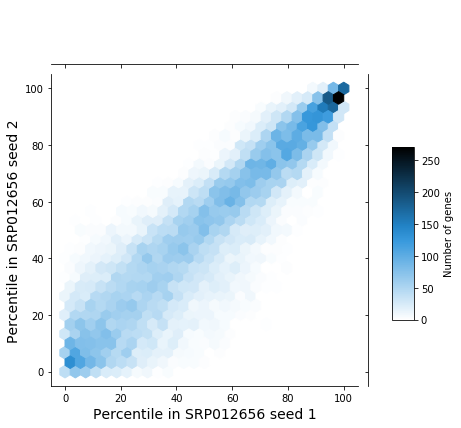

In [10]:
# Plot correlation between ranking
r, p = stats.spearmanr(
    gene_ranking_same_combined["Percentile 1"],
    gene_ranking_same_combined["Percentile 2"],
)
print(r, p)

fig = sns.jointplot(
    data=gene_ranking_same_combined,
    x="Percentile 1",
    y="Percentile 2",
    kind="hex",
    marginal_kws={"color": "white", "edgecolor": "white"},
)

fig.set_axis_labels(
    f"Percentile in {project_id1} seed 1",
    f"Percentile in {project_id1} seed 2",
    fontsize=14,
    fontname="Verdana",
)
cbar_ax = fig.fig.add_axes([0.9, 0.25, 0.05, 0.4])  # x, y, width, height
cb = plt.colorbar(cax=cbar_ax)
cb.set_label("Number of genes")

output_figure_filename = "concordance_between_same_recount2_templates.svg"
fig.savefig(
    output_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* Running SOPHIE twice using the same template experiment will generate 2 different sets of simulated experiments.
* Since the template experiment is the same, these 2 sets of simulated experiments will have the same experimental design structure/biological context
* As expected, the concordance is very high especially for high ranked and low ranked genes. The genes in the middle rank are more sensitive to changes so you don't get as clear of a signal compared to the extreme ranked genes.

## Correlation between rankings between 2 different experiments

Here we compare gene ranking generated by SOPHIE using 2 different template experiments.

In [11]:
# Load gene ranking
gene_ranking_summary2 = pd.read_csv(
    gene_ranking_filename2, sep="\t", index_col=0, header=0
)

In [12]:
# Get simulated ranking
gene_ranking1 = (
    gene_ranking_summary1["Rank (simulated)"].rename("Rank 1").to_frame("Rank 1")
)
gene_ranking2 = (
    gene_ranking_summary2["Rank (simulated)"].rename("Rank 2").to_frame("Rank 2")
)

In [13]:
# Scale ranking to percentile (0,100)
scaler = MinMaxScaler(feature_range=(0, 100))

gene_ranking1["Percentile 1"] = scaler.fit_transform(
    np.array(gene_ranking1["Rank 1"]).reshape(-1, 1)
)

gene_ranking2["Percentile 2"] = scaler.fit_transform(
    np.array(gene_ranking2["Rank 2"]).reshape(-1, 1)
)

gene_ranking2.head()

,Rank 2,Percentile 2
PDLIM4,16422.0,92.491833
LRCH2,10717.0,60.358229
NAA11,15614.0,87.940746
ALOX15B,15490.0,87.242312
GABRG1,17399.0,97.994818


In [14]:
# Combine ranking
gene_ranking_diff_combined = pd.concat(
    [gene_ranking1["Percentile 1"], gene_ranking2["Percentile 2"]], axis=1
)

/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
print(gene_ranking_diff_combined.shape)
gene_ranking_diff_combined.head()

(17755, 2)


,Percentile 1,Percentile 2
A1BG,81.868875,61.783260
A1BG.AS1,57.846119,20.637603
A1CF,96.231835,86.363636
A2M,67.049679,63.444857
A2M.AS1,67.066577,69.663174


In [16]:
# Check for NAs
gene_ranking_diff_combined[pd.isnull(gene_ranking_diff_combined).any(axis=1)]

,Percentile 1,Percentile 2


0.5715129950742085 0.0


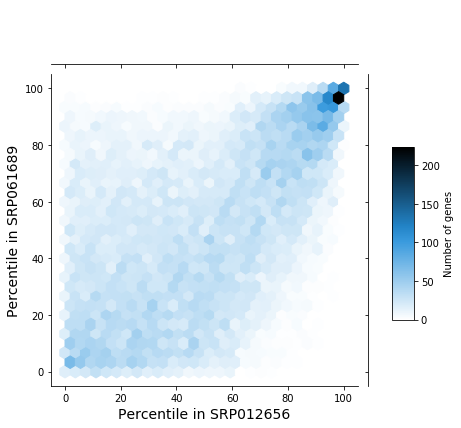

In [17]:
# Plot correlation between ranking
r, p = stats.spearmanr(
    gene_ranking_diff_combined["Percentile 1"],
    gene_ranking_diff_combined["Percentile 2"],
)
print(r, p)

fig = sns.jointplot(
    data=gene_ranking_diff_combined,
    x="Percentile 1",
    y="Percentile 2",
    kind="hex",
    marginal_kws={"color": "white", "edgecolor": "white"},
)

fig.set_axis_labels(
    f"Percentile in {project_id1}",
    f"Percentile in {project_id2}",
    fontsize=14,
    fontname="Verdana",
)

cbar_ax = fig.fig.add_axes([0.9, 0.25, 0.05, 0.4])  # x, y, width, height
cb = plt.colorbar(cax=cbar_ax)
cb.set_label("Number of genes")

output_figure_filename = "concordance_between_diff_recount2_templates.svg"
fig.savefig(
    output_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**

* Looks like there is good concordance between highly ranked genes (i.e. generic genes)
* By comparison if we run SOPHIE using two different template experiments, there are genes in the off-diagonal regions that might indicate that there are generic within the given context of the specific experiment.
* In general, the genes in the middle rank are more sensitive to changes so you don't get as clear of a signal compared to the highest rank genes.

## Examine gene expression data

In [18]:
# Read expression data
template_1 = pd.read_csv(template_filename1, sep="\t", index_col=0, header=0)
template_2 = pd.read_csv(template_filename2, sep="\t", index_col=0, header=0)

In [19]:
# Get concordance genes
concordant_genes = list(
    gene_ranking_diff_combined[
        (gene_ranking_diff_combined["Percentile 1"] > 80)
        & (gene_ranking_diff_combined["Percentile 2"] > 80)
    ].index
)

# Get disconcordant genes
discordant_genes = set(gene_ranking_diff_combined.index).difference(concordant_genes)

Percent concordant genes with 0 expression in template 1: 0.054292343387471
Percent nonzero concordant genes in template 1: 0.8361948955916473


/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[None, None]

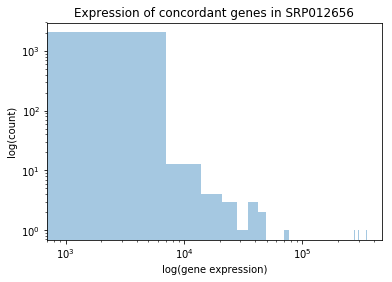

In [20]:
# Distribution of concordant genes in template experiment 1
template1_mean = template_1.mean()

print(
    "Percent concordant genes with 0 expression in template 1:",
    len(template1_mean[concordant_genes].loc[template1_mean[concordant_genes] == 0])
    / len(template1_mean[concordant_genes]),
)

print(
    "Percent nonzero concordant genes in template 1:",
    len(
        template1_mean[concordant_genes].loc[
            (template1_mean[concordant_genes] > 0)
            & (template1_mean[concordant_genes] < 1000)
        ]
    )
    / len(template1_mean[concordant_genes]),
)

f1 = sns.distplot(template_1.mean()[concordant_genes], kde=False)
f1.set_title(f"Expression of concordant genes in {project_id1}")
f1.set_xlabel("log(gene expression)")
f1.set_ylabel("log(count)")
f1.set(xscale="log", yscale="log")

Percent concordant genes with 0 expression in template 2: 0.37726218097447795
Percent nonzero concordant genes in template 2: 0.5624129930394431


[None, None]

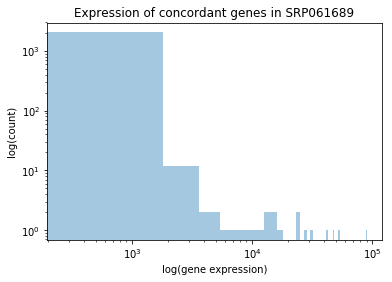

In [21]:
# Distribution of concordant genes in template experiment 2
template2_mean = template_2.mean()
print(
    "Percent concordant genes with 0 expression in template 2:",
    len(template2_mean[concordant_genes].loc[template2_mean[concordant_genes] == 0])
    / len(template2_mean[concordant_genes]),
)

print(
    "Percent nonzero concordant genes in template 2:",
    len(
        template2_mean[concordant_genes].loc[
            (template2_mean[concordant_genes] > 0)
            & (template2_mean[concordant_genes] < 1000)
        ]
    )
    / len(template2_mean[concordant_genes]),
)

# There are more 0 expressed genes in this template experiment
f2 = sns.distplot(template_2.mean()[concordant_genes], kde=False)
f2.set_title(f"Expression of concordant genes in {project_id2}")
f2.set_xlabel("log(gene expression)")
f2.set_ylabel("log(count)")
f2.set(xscale="log", yscale="log")

Percent discordant genes with 0 expression in template 1: 0.0033333333333333335
Percent nonzero discordant genes in template 1: 0.5617948717948718
0.9638461538461538


[None, None]

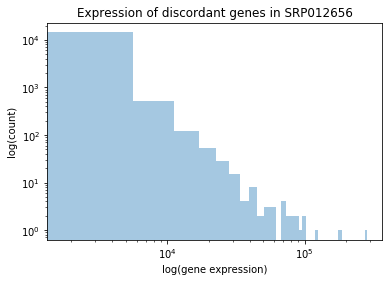

In [22]:
# Distribution of discordant gense in template experiment 1
template1_mean = template_1.mean()

print(
    "Percent discordant genes with 0 expression in template 1:",
    len(template1_mean[discordant_genes].loc[template1_mean[discordant_genes] == 0])
    / len(template1_mean[discordant_genes]),
)

print(
    "Percent nonzero discordant genes in template 1:",
    len(
        template1_mean[discordant_genes].loc[
            (template1_mean[discordant_genes] > 0)
            & (template1_mean[discordant_genes] < 1000)
        ]
    )
    / len(template1_mean[discordant_genes]),
)

print(
    len(template1_mean[discordant_genes].loc[template1_mean[discordant_genes] > 0])
    / len(template1_mean[discordant_genes])
)
f3 = sns.distplot(template_1.mean()[discordant_genes], kde=False)
f3.set_title(f"Expression of discordant genes in {project_id1}")
f3.set_xlabel("log(gene expression)")
f3.set_ylabel("log(count)")
f3.set(xscale="log", yscale="log")

Percent discordant genes with 0 expression in template 2: 0.05211538461538461
Percent nonzero discordant genes in template 2: 0.565


[None, None]

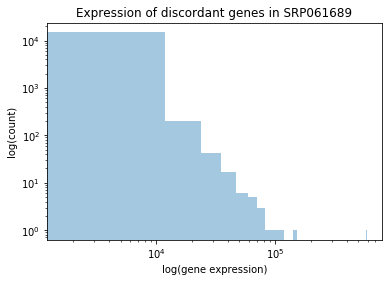

In [23]:
# Distribution of discordant genes in template experiment 2
template2_mean = template_2.mean()

print(
    "Percent discordant genes with 0 expression in template 2:",
    len(template2_mean[discordant_genes].loc[template2_mean[discordant_genes] == 0])
    / len(template2_mean[discordant_genes]),
)

print(
    "Percent nonzero discordant genes in template 2:",
    len(
        template2_mean[discordant_genes].loc[
            (template2_mean[discordant_genes] > 0)
            & (template2_mean[discordant_genes] < 1000)
        ]
    )
    / len(template2_mean[discordant_genes]),
)

f4 = sns.distplot(template_2.mean()[discordant_genes], kde=False)
f4.set_title(f"Expression of discordant genes in {project_id2}")
f4.set_xlabel("log(gene expression)")
f4.set_ylabel("log(count)")
f4.set(xscale="log", yscale="log")

**Takeaway:**

Doesn't appear to be much of a difference between the distribution of average gene expression values for these two experiments.

Theoretically, I would expect the scenario where a gene is lowly expressed in the context of template experiment 1 and therefore not found to be generic. But this same gene could be found to be generic in the context of template experiment 2 if it is more expressed. Its possible that differences in gene expression distribution can change which genes are found to be generic given that the simulation is producing experiments with a similar context.

In this case, despite having similar gene expression distributions there are still many differences in gene ranking. This suggests to me that level of gene expression activity doesn't matter as much as the overall patterns perhaps.

Overall we observe a slight shift showing that concordant genes are more lowly expressed compared to discordant genes, but most genes are still predominantly lowly gene expression. If most genes have expression levels very close to 0, then small fluctuations in the expression of some genes could lead to large changes in rank without changing the overall expression distribution.